<a href="https://colab.research.google.com/github/sjamillah/Cardio-Vascular_Pipeline/blob/main/Cardio_Vascular_System_Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chronic Disease Management System: Machine Learning Workflow**
## Project Overview

This Colab notebook demonstrates the machine learning pipeline for a Chronic Disease Management System, focusing on predicting cardiovascular disease risks using advanced data preprocessing and neural network techniques.

## Table of Contents

1. Data Loading and Preprocessing
2. Feature Visualization
2. Data Scaling and Splitting
3. Neural Network Model Creation
4. Model Training
5. Model Evaluation
6. Fine-Tuning
7. Visualization of Results




## 1. Setup and Imports

In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import joblib
import os
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## 2. Data Loading and Preprocessing
### 2.1 Data Preprocessing Function
The `load_and_preprocess_data` function handles:

* Filtering relevant features
* Adding synthetic categorical variables
* Creating risk level categorization
* One-hot encoding

In [ ]:
def load_and_preprocess_data(file_path):
    """
    Load and preprocess the cardiovascular dataset

    Args:
        file_path (str): Path to the CSV file

    Returns:
        tuple: Processed features (X) and risk level (Y)
    """
    data = pd.read_csv(file_path, delimiter=";")

    relevant_features = ['age', 'height', 'weight', 'gender', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc']
    data_filtered = data[relevant_features + ['cardio']]

    np.random.seed(42)

    cultural_belief_categories = ['Never', 'Occasionally', 'Frequently']
    data_filtered.loc[:, 'cultural_belief_score'] = np.random.choice(cultural_belief_categories, len(data_filtered))

    treatment_adherence = ['Low', 'Medium', 'High']
    data_filtered.loc[:, 'treatment_adherence'] = np.random.choice(treatment_adherence, len(data_filtered))

    distance_categories = ['Near', 'Moderate', 'Far']
    data_filtered.loc[:, 'distance_to_healthcare'] = np.random.choice(distance_categories, len(data_filtered))

    synthetic_notes = [
        "Patient shows high BP, high cholesterol, obesity-related risks. Echocardiogram suggests early-stage RHD.",
        "Mild hypertension noted. Controlled glucose levels. Moderate adherence to medication.",
        "History of tobacco use. Symptoms indicate potential COPD overlap. Needs lifestyle intervention.",
        "Shortness of breath and fatigue reported. Distance to care facility may impact treatment adherence."
    ]
    data_filtered['clinical_notes'] = np.random.choice(synthetic_notes, len(data_filtered))

    data_filtered.loc[:, 'risk_level'] = np.select(
        [
            (data_filtered['ap_hi'] <= 140) & (data_filtered['cholesterol'] <= 1) & (data_filtered['gluc'] <= 1),
            ((data_filtered['ap_hi'] > 140) & (data_filtered['ap_hi'] <= 160)) | (data_filtered['cholesterol'] == 2) | (data_filtered['gluc'] == 2),
            (data_filtered['ap_hi'] > 160) | (data_filtered['cholesterol'] > 2) | (data_filtered['gluc'] > 2)
        ],
        [0, 1, 2],
        default=1
    )

    data_filtered.drop('cardio', axis=1, inplace=True)

    relevant_features = [
        'age', 'height', 'weight', 'gender', 'ap_hi', 'ap_lo',
        'cholesterol', 'gluc', 'cultural_belief_score',
        'treatment_adherence', 'distance_to_healthcare'
    ]
    data_filtered = data_filtered[relevant_features + ['risk_level']]

    data_processed = pd.get_dummies(data_filtered, drop_first=True)

    X = data_processed.drop('risk_level', axis=1)
    Y = data_processed['risk_level']

    return X, Y


file_path = '/content/cardio_train.csv'

print("Loading and preprocessing data...")
X, Y = load_and_preprocess_data(file_path)
print(f"Data loaded successfully. Features shape: {X.shape}, Target shape: {Y.shape}")

Loading and preprocessing data...


<ipython-input-88-8bba347f0271>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.loc[:, 'cultural_belief_score'] = np.random.choice(cultural_belief_categories, len(data_filtered))
<ipython-input-88-8bba347f0271>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.loc[:, 'treatment_adherence'] = np.random.choice(treatment_adherence, len(data_filtered))
<ipython-input-88-8bba347f0271>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

Data loaded successfully. Features shape: (70000, 14), Target shape: (70000,)


## 3. Feature Visualization
### 3.1 Correlation Heatmap
Visualizing feature correlations to understand relationships between different health indicators.

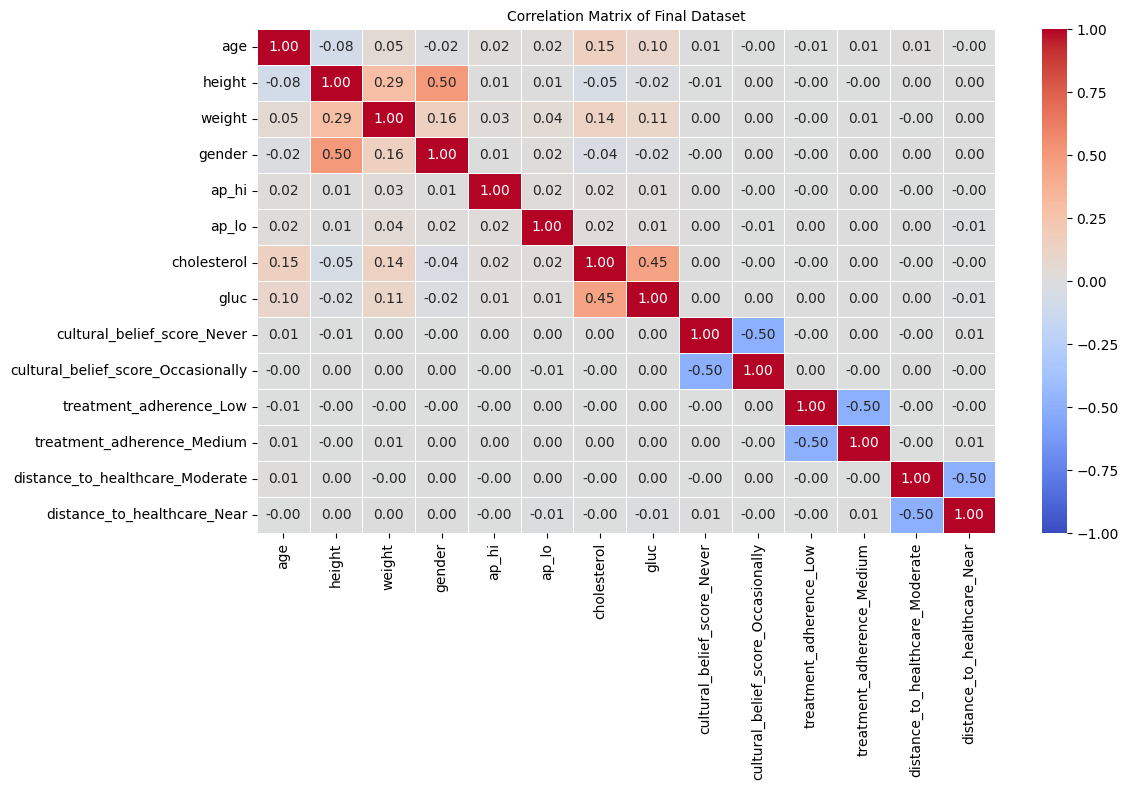

In [ ]:
def visualize_correlations(data):
    """
    Visualize feature correlations

    Args:
        data (pd.DataFrame): Processed dataset
    """
    correlation_matrix = data.corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm",
                cbar=True, linewidths=0.5, vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Final Dataset', fontsize=10)
    plt.tight_layout()
    plt.show()


visualize_correlations(X)

## 4. Data Scaling and Splitting
### 4.1 Train-Validation-Test Split
Splitting data and scaling features to prepare for model training.

In [ ]:
def split_and_scale_data(X, Y, test_size=0.3, val_size=0.2):
    """
    Split data into train, validation, and test sets and scale features

    Args:
        X (pd.DataFrame): Features
        Y (pd.Series): Target variable
        test_size (float): Proportion of data for test set
        val_size (float): Proportion of remaining data for validation set

    Returns:
        tuple: Scaled train, validation, and test sets for X and Y
    """
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=test_size, random_state=42)

    X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=val_size, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return (X_train_scaled, X_val_scaled, X_test_scaled,
            Y_train, Y_val, Y_test, scaler)


print("\nSplitting and scaling data...")
X_train_scaled, X_val_scaled, X_test_scaled, Y_train, Y_val, Y_test, scaler = split_and_scale_data(X, Y)
print(f"Data split completed. Training set size: {X_train_scaled.shape[0]}, Validation set size: {X_val_scaled.shape[0]}, Test set size: {X_test_scaled.shape[0]}")


Splitting and scaling data...
Data split completed. Training set size: 49000, Validation set size: 16800, Test set size: 4200


## 5. Neural Network Model Creation
### 5.1 Configurable Neural Network Architecture
A flexible neural network model creation function with various configuration options:

* Multiple optimization algorithms
* Regularization techniques
* Dropout layers
* Different model architectures

In [ ]:
def create_neural_network_model(
    input_shape,
    num_classes,
    model_type="default",
    optimization="adam",
    regularization_type=None,
    reg_value=0.1,
    dropout=0.0,
    learning_rate=0.002
):
    """
    Create a neural network model with configurable architecture

    Args:
        input_shape (int): Number of input features
        num_classes (int): Number of output classes
        model_type (str): Model architecture variant
        optimization (str): Optimizer type
        regularization_type (str): Type of regularization (l1 or l2)
        reg_value (float): Regularization strength
        dropout (float): Dropout rate
        learning_rate (float): Learning rate for optimizer

    Returns:
        tuple: Compiled Keras model and optimizer
    """
    if regularization_type == "l1":
        regularizer = l1(reg_value)
    elif regularization_type == "l2":
        regularizer = l2(reg_value)
    else:
        regularizer = None

    model = Sequential()

    if model_type == "model1":
        model.add(Dense(256, activation='relu', input_shape=(input_shape,)))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(num_classes, activation='softmax'))
    else:
        model.add(Dense(256, activation='relu', input_shape=(input_shape,), kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        if dropout > 0:
            model.add(Dropout(dropout))
        model.add(Dense(128, activation='relu', kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        if dropout > 0:
            model.add(Dropout(dropout))
        model.add(Dense(64, activation='relu', kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        if dropout > 0:
            model.add(Dropout(dropout))
        model.add(Dense(32, activation='relu', kernel_regularizer=regularizer))
        model.add(BatchNormalization())
        if dropout > 0:
            model.add(Dropout(dropout))
        model.add(Dense(16, activation='relu', kernel_regularizer=regularizer))
        model.add(Dense(8, activation='relu', kernel_regularizer=regularizer))
        model.add(Dense(num_classes, activation='softmax'))

    optimizers = {
        "adam": Adam(learning_rate=learning_rate),
        "sgd": SGD(learning_rate=learning_rate),
        "rmsprop": RMSprop(learning_rate=learning_rate)
    }
    optimizer = optimizers.get(optimization, Adam(learning_rate=learning_rate))

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model


## 6. Model Training and Saving
### 6.1 Neural Network Training Function
Training neural network models with configurable parameters and optional early stopping and saving them.

In [ ]:
def train_neural_network(
    model,
    X_train,
    Y_train,
    X_val,
    Y_val,
    epochs=50,
    batch_size=32,
    early_stopping=False,
    patience=5
):
    """
    Train a neural network model

    Args:
        model (keras.Model): Compiled Keras model
        X_train (np.array): Training features
        Y_train (np.array): Training labels
        X_val (np.array): Validation features
        Y_val (np.array): Validation labels
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        early_stopping (bool): Whether to use early stopping
        patience (int): Patience for early stopping

    Returns:
        tuple: Trained model and training history
    """
    callbacks = []
    if early_stopping:
        early_stopping_callback = EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1)
        callbacks.append(early_stopping_callback)

    history = model.fit(
        X_train, Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        callbacks=callbacks
    )

    return model, history

In [ ]:
print("\nCreating and training a simple neural network model...")
num_classes = len(np.unique(Y))
simple_model = create_neural_network_model(
    input_shape=X_train_scaled.shape[1],
    num_classes=num_classes,
    model_type="model1",
    optimization="adam"
)
trained_simple_model, history = train_neural_network(
    simple_model,
    X_train_scaled,
    Y_train,
    X_val_scaled,
    Y_val,
    epochs=5,
    batch_size=32
)


Creating and training a simple neural network model...
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1532/1532 ━━━━━━━━━━━━━━━━━━━━ 29s 13ms/step - accuracy: 0.8905 - loss: 0.2892 - val_accuracy: 0.9695 - val_loss: 0.0898
Epoch 2/5
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9700 - loss: 0.0944 - val_accuracy: 0.9807 - val_loss: 0.0615
Epoch 3/5
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9830 - loss: 0.0584 - val_accuracy: 0.9920 - val_loss: 0.0394
Epoch 4/5
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9875 - loss: 0.0380 - val_accuracy: 0.9946 - val_loss: 0.0234
Epoch 5/5
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9918 - loss: 0.0278 - val_accuracy: 0.9930 - val_loss: 0.0203


In [ ]:
def train_and_save_models(X_train, Y_train, X_val, Y_val, num_classes):
    """
    Train multiple neural network models and SVM model, save them

    Args:
        X_train (np.array): Training features
        Y_train (np.array): Training labels
        X_val (np.array): Validation features
        Y_val (np.array): Validation labels
        num_classes (int): Number of output classes

    Returns:
        dict: Trained models and their histories
    """
    model_configs = [
        {
            "name": "model_default",
            "type": "model1",
            "optimization": "adam",
            "early_stopping": False,
            "regularization_type": None,
            "reg_value": 0.0,
            "dropout": 0.0,
            "epochs": 20,
            "learning_rate": 0.0
        },
        {
            "name": "model_adam",
            "type": "model2",
            "optimization": "adam",
            "early_stopping": True,
            "regularization_type": "l2",
            "reg_value": 0.2,
            "dropout": 0.5,
            "epochs": 150,
            "learning_rate": 0.001
        },
        {
            "name": "model_sgd",
            "type": "model3",
            "optimization": "sgd",
            "early_stopping": True,
            "regularization_type": "l2",
            "reg_value": 0.1,
            "dropout": 0.4,
            "epochs": 500,
            "learning_rate": 0.006
        },
        {
            "name": "model_rmsprop",
            "type": "model4",
            "optimization": "rmsprop",
            "early_stopping": True,
            "regularization_type": "l2",
            "reg_value": 0.02,
            "dropout": 0.1,
            "epochs": 200,
            "learning_rate": 0.001
        }
    ]

    trained_models = {}
    model_history = {}

    for config in model_configs:
        print(f"Training {config['name']}...")

        model = create_neural_network_model(
            input_shape=X_train.shape[1],
            num_classes=num_classes,
            model_type=config['type'],
            optimization=config['optimization'],
            regularization_type=config['regularization_type'],
            reg_value=config.get('reg_value', 0.1),
            dropout=config.get('dropout', 0.0),
            learning_rate=config['learning_rate']
        )

        trained_model, history = train_neural_network(
            model,
            X_train,
            Y_train,
            X_val,
            Y_val,
            epochs=config['epochs'],
            early_stopping=config['early_stopping']
        )

        joblib.dump(trained_model, f"{config['name']}.pkl")
        trained_models[config['name']] = trained_model
        model_history[config['name']] = history

    svm_model = SVC(kernel='linear', C=1.0, gamma='scale')
    svm_model.fit(X_train, Y_train)

    joblib.dump(svm_model, "model_svm.pkl")
    trained_models['svm'] = svm_model

    return trained_models, model_history

In [ ]:
print("\nTraining and saving multiple models...")
trained_models, model_history = train_and_save_models(X_train_scaled, Y_train, X_val_scaled, Y_val, num_classes)
print("Models trained and saved successfully.")


Training and saving multiple models...
Training model_default...
Epoch 1/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6101 - loss: 1.0824 - val_accuracy: 0.6127 - val_loss: 1.0823
Epoch 2/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6122 - loss: 1.0821 - val_accuracy: 0.6127 - val_loss: 1.0823
Epoch 3/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6115 - loss: 1.0824 - val_accuracy: 0.6127 - val_loss: 1.0823
Epoch 4/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6126 - loss: 1.0821 - val_accuracy: 0.6127 - val_loss: 1.0823
Epoch 5/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6116 - loss: 1.0824 - val_accuracy: 0.6127 - val_loss: 1.0823
Epoch 6/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.6133 - loss: 1.0823 - val_accuracy: 0.6127 - val_loss: 1.0823
Epoch 7/20
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.6122 - loss: 1.0824 - val_accuracy: 0.6127 - val_loss: 1.0823
Epoch 8/20
1532/1532

## 6. Model Evaluation
### 6.1 Model Performance Metrics
Evaluating models using confusion matrices and classification reports.

In [ ]:
def evaluate_models(X_test, Y_test, model_paths):
    """
    Evaluate multiple models and print classification reports

    Args:
        X_test (np.array): Test features
        Y_test (np.array): Test labels
        model_paths (list): List of paths to saved models

    Returns:
        dict: Model evaluation metrics
    """
    evaluation_results = {}

    for model_path in model_paths:
        if model_path.endswith('.pkl'):
            model = joblib.load(model_path)
            y_pred = model.predict(X_test)

            if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
                y_pred = np.argmax(y_pred, axis=1)

        else:
            model = load_model(model_path)
            y_pred = np.argmax(model.predict(X_test), axis=1)

        model_name = model_path.split('/')[-1].split('.')[0]

        conf_matrix = confusion_matrix(Y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

        if len(Y_test.shape) > 1 and Y_test.shape[1] > 1:
            Y_test = np.argmax(Y_test, axis=1)

        report = classification_report(Y_test, y_pred, output_dict=True)
        print(f'\n{model_name} Classification Report:')
        print(classification_report(Y_test, y_pred))

        evaluation_results[model_name] = report

    return evaluation_results


Evaluating trained models...
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


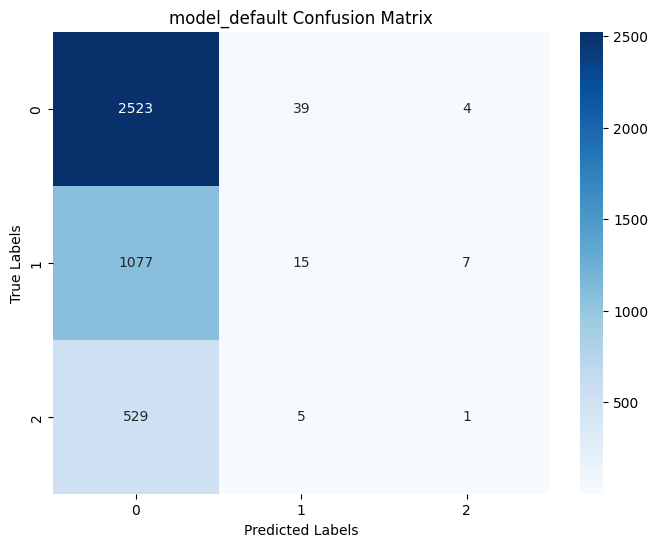


model_default Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.98      0.75      2566
           1       0.25      0.01      0.03      1099
           2       0.08      0.00      0.00       535

    accuracy                           0.60      4200
   macro avg       0.32      0.33      0.26      4200
weighted avg       0.45      0.60      0.47      4200

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


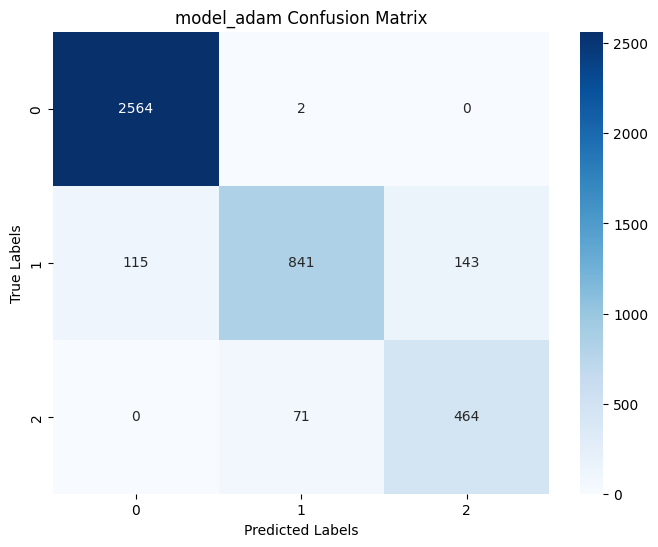


model_adam Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2566
           1       0.92      0.77      0.84      1099
           2       0.76      0.87      0.81       535

    accuracy                           0.92      4200
   macro avg       0.88      0.88      0.88      4200
weighted avg       0.92      0.92      0.92      4200

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


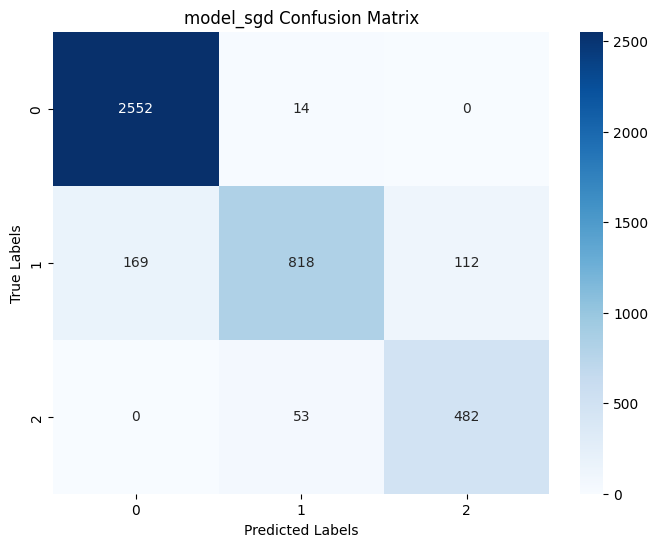


model_sgd Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2566
           1       0.92      0.74      0.82      1099
           2       0.81      0.90      0.85       535

    accuracy                           0.92      4200
   macro avg       0.89      0.88      0.88      4200
weighted avg       0.92      0.92      0.91      4200

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


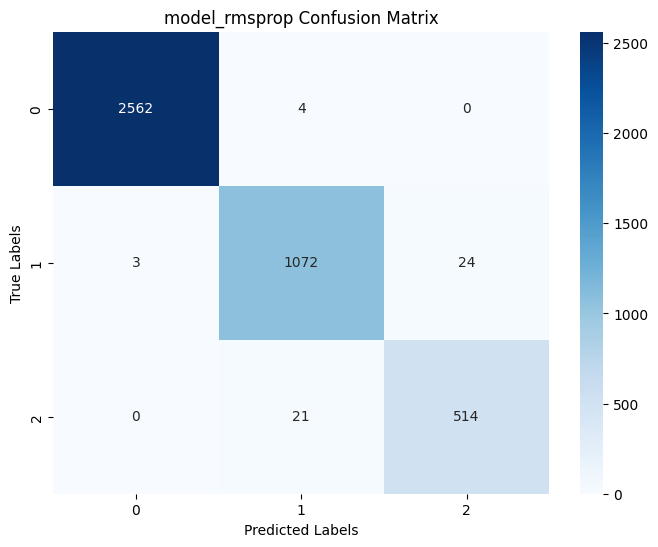


model_rmsprop Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2566
           1       0.98      0.98      0.98      1099
           2       0.96      0.96      0.96       535

    accuracy                           0.99      4200
   macro avg       0.98      0.98      0.98      4200
weighted avg       0.99      0.99      0.99      4200



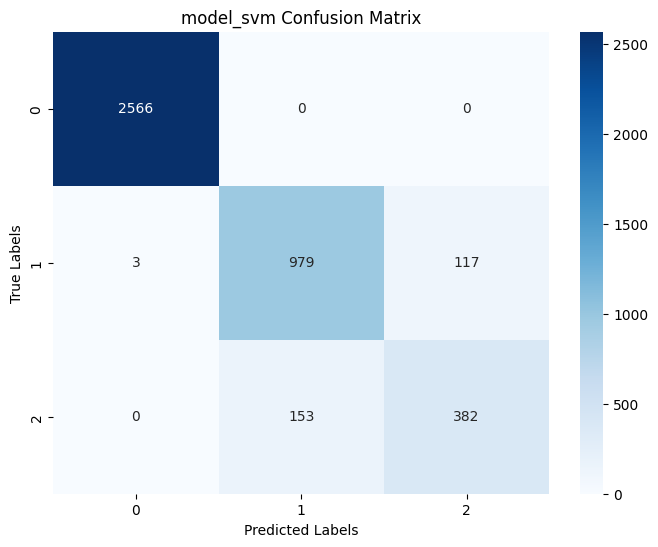


model_svm Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2566
           1       0.86      0.89      0.88      1099
           2       0.77      0.71      0.74       535

    accuracy                           0.94      4200
   macro avg       0.88      0.87      0.87      4200
weighted avg       0.93      0.94      0.93      4200


Evaluation completed. Summary of model accuracies:
model_default: 60.45%
model_adam: 92.12%
model_sgd: 91.71%
model_rmsprop: 98.76%
model_svm: 93.50%


In [ ]:
print("\nEvaluating trained models...")

model_paths = [
    f"{model_name}.pkl" for model_name in ['model_default', 'model_adam', 'model_sgd', 'model_rmsprop', 'model_svm']
]

evaluation_results = evaluate_models(X_test_scaled, Y_test, model_paths)

print("\nEvaluation completed. Summary of model accuracies:")
for model_name, results in evaluation_results.items():
    print(f"{model_name}: {results['accuracy'] * 100:.2f}%")

### 6.2 Training Curves Visualization
Plotting loss and accuracy curves for trained models.

In [ ]:
def plot_loss_and_accuracy_curves(histories):
    """
    Plot loss and accuracy curves for multiple models.

    Args:
        histories (dict): Dictionary of model training histories
    """
    for name, history in histories.items():
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        axes[0].plot(history.history['loss'], label='Training Loss', color='blue')
        axes[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
        axes[0].set_title(f'{name} - Loss Curve', fontsize=14)
        axes[0].set_xlabel('Epochs', fontsize=12)
        axes[0].set_ylabel('Loss', fontsize=12)
        axes[0].legend()
        axes[0].grid(True)

        if 'accuracy' in history.history:
            axes[1].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
            axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
            axes[1].set_title(f'{name} - Accuracy Curve', fontsize=14)
            axes[1].set_xlabel('Epochs', fontsize=12)
            axes[1].set_ylabel('Accuracy', fontsize=12)
            axes[1].legend()
            axes[1].grid(True)

        plt.tight_layout()
        plt.show()


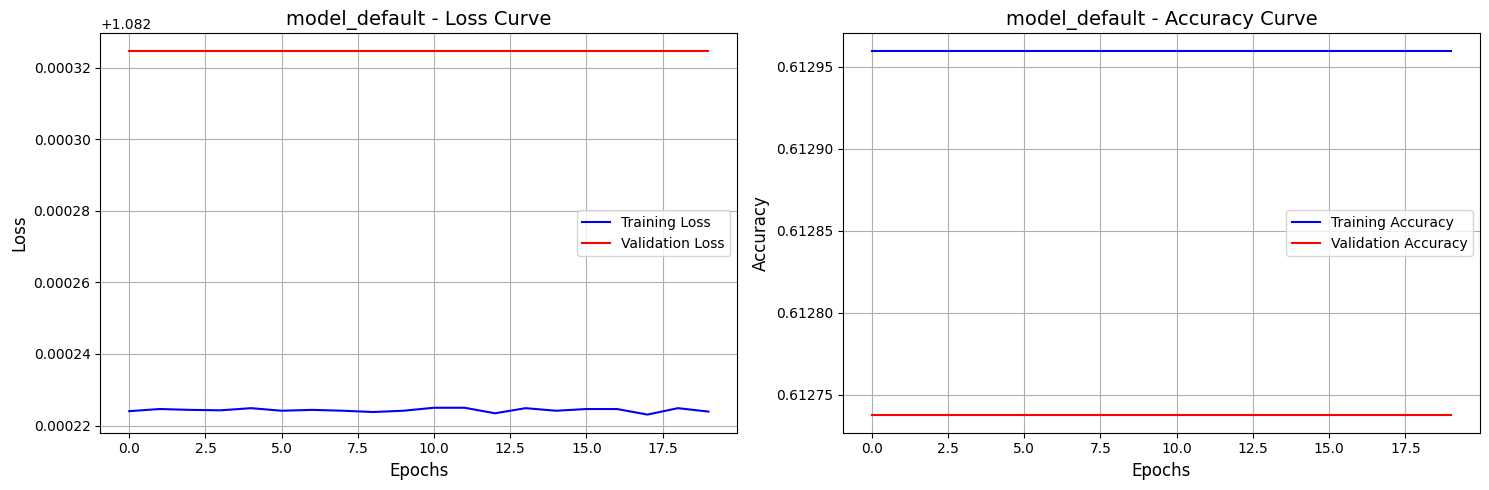

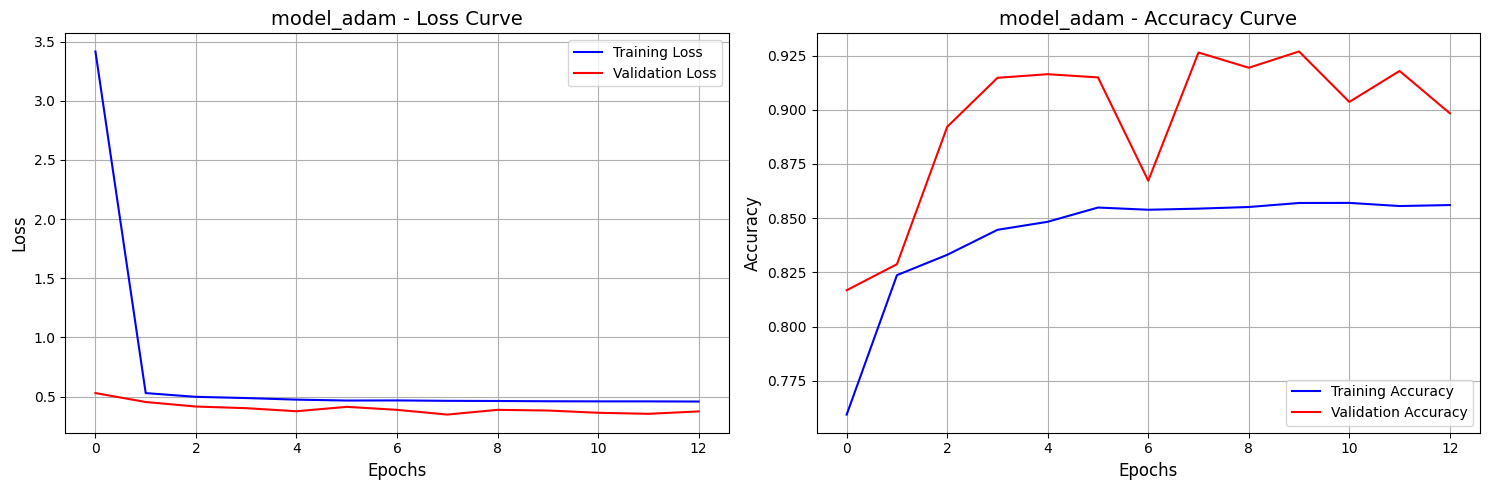

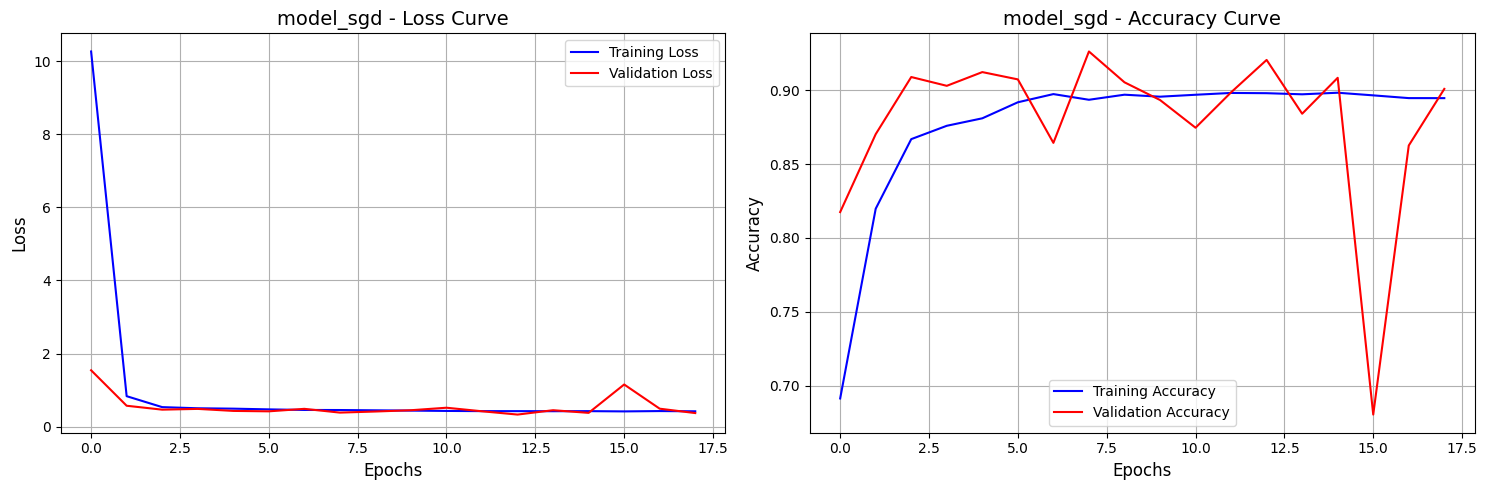

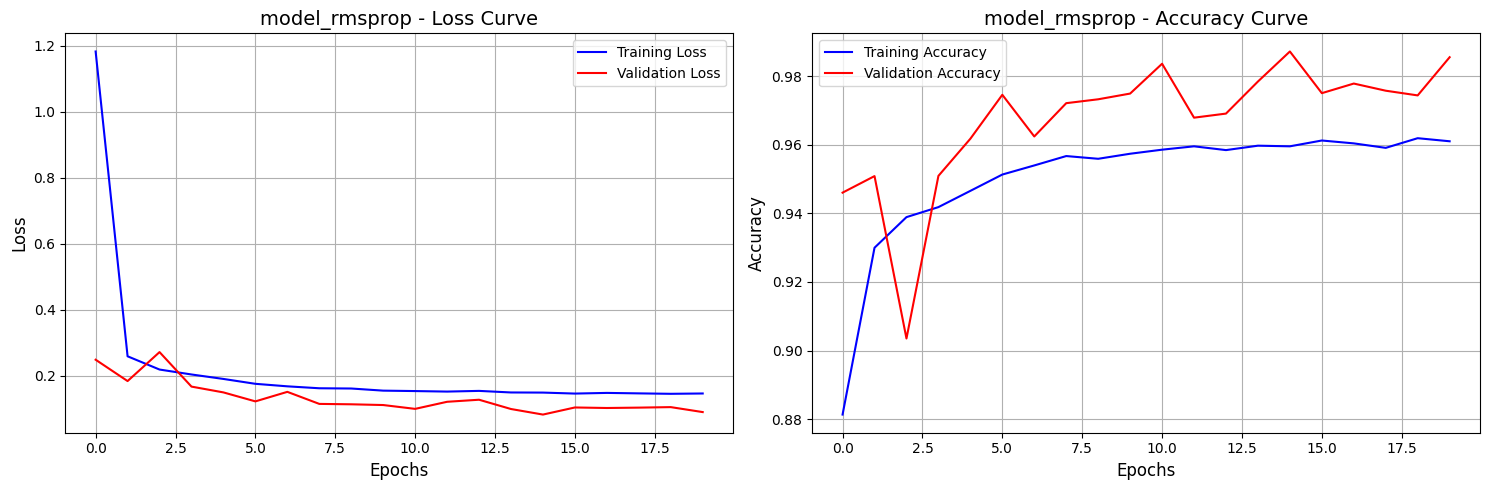

In [ ]:
plot_loss_and_accuracy_curves(model_history)

## Predictions
Make predictions using the best performing model

In [ ]:
def predict_risk(model_path, X_input):
    """
    Make predictions using a saved model

    Args:
        model_path (str): Path to the saved model
        X_input (np.array): Input features to predict

    Returns:
        np.array: Predicted risk levels
    """
    if model_path.endswith('.pkl'):
        model = joblib.load(model_path)
        predictions = model.predict(X_input)
    else:
        model = load_model(model_path)
        predictions = np.argmax(model.predict(X_input), axis=1)

    return predictions

In [ ]:
predict_risk('model_rmsprop.pkl', X_test_scaled)

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([[2.3038942e-02, 3.3584133e-01, 6.4111972e-01],
       [5.5123544e-03, 9.4933814e-01, 4.5149531e-02],
       [8.9411234e-04, 9.9571854e-01, 3.3872705e-03],
       ...,
       [9.9930286e-01, 6.9246191e-04, 4.8052007e-06],
       [4.6065487e-03, 9.5206726e-01, 4.3326143e-02],
       [9.9980354e-01, 1.9561224e-04, 8.5029774e-07]], dtype=float32)

## 8. Fine-Tuning
### 8.1 Model Fine-Tuning
Fine-tuning existing models and retraining.

In [ ]:
model_paths = ["model_rmsprop.pkl"]

for model_path in model_paths:
    print(f"\nLoading model: {model_path}")

    try:
        if model_path.endswith(".pkl"):  # Check if it's a .pkl file
            model = joblib.load(model_path)  # Load model
            if hasattr(model, "summary"):
                model.summary()  # Display full structure
            else:
                print(model)  # Print details if not a Keras model
        else:  # If it's a standard Keras model (e.g., .h5)
            model = load_model(model_path)
            model.summary()  # Print model architecture

    except Exception as e:
        print(f"Error loading {model_path}: {e}")



Loading model: model_rmsprop.pkl


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                     │ (None, 256)                 │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,408 (384.41 KB)

 Trainable params: 48,723 (190.32 KB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 48,725 (190.34 KB)

In [ ]:
def fine_tune_model(
    model_path,
    X_train,
    Y_train,
    X_val,
    Y_val,
    output_dir="fine_tuned_models",
    batch_size=32,
    epochs=200,
    patience=20,
    learning_rate=0.0001
):
    """
    Fine-tune an existing model with minimal structural changes.

    Parameters
    ----------
    model_path : str
        Path to the model to be fine-tuned.
    X_train : array-like
        Training feature dataset.
    Y_train : array-like
        Training label dataset.
    X_val : array-like
        Validation feature dataset.
    Y_val : array-like
        Validation label dataset.
    output_dir : str, optional
        Directory to save fine-tuned model (default is "fine_tuned_models").
    batch_size : int, optional
        Training batch size
    epochs : int, optional
        Maximum number of training epochs
    patience : int
        Early stopping patience.
    learning_rate : float
        Learning rate for fine-tuning.

    Returns
    -------
    tuple
        A tuple containing:
        - Fine-tuned model
        - Training history
        - Path to the fine-tuned model
    """
    try:
        print(f"Loading model from {model_path} for fine-tuning...")

        if model_path.endswith('.pkl'):
            import joblib
            model = joblib.load(model_path)
        else:
            raise ValueError(f"Unsupported model format: {model_path}")

    except Exception as e:
        raise ValueError(f"Failed to load model from {model_path}: {e}")

    # Preprocess labels
    if len(Y_train.shape) > 1 and Y_train.shape[1] > 1:
        Y_train = np.argmax(Y_train, axis=1)
    if len(Y_val.shape) > 1 and Y_val.shape[1] > 1:
        Y_val = np.argmax(Y_val, axis=1)

    Y_train = Y_train.astype(int)
    Y_val = Y_val.astype(int)

    # Verify model can be fine-tuned
    if not hasattr(model, 'compile'):
        raise ValueError("The loaded model is not a Keras model that can be fine-tuned.")

    # Recompile with low learning rate
    model.compile(
        optimizer=RMSprop(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Enhanced callbacks
    callbacks = [
        # Save best model
        ModelCheckpoint(
            filepath=os.path.join(output_dir, "best_fine_tuned_model.h5"),
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
        # Early stopping with restored best weights
        EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            min_delta=0.001,
            verbose=1
        ),
        # Adaptive learning rate reduction
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        )
    ]

    print("\nModel Summary Before Fine-Tuning:")
    model.summary()

    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    print(f"\nTotal Trainable Parameters: {trainable_params}")

    print("\nStarting fine-tuning process...")
    history = model.fit(
        X_train,
        Y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, Y_val),
        callbacks=callbacks,
        verbose=1
    )

    fine_tuned_model_path = os.path.join(output_dir, "fine_tuned_model.h5")
    model.save(fine_tuned_model_path)
    print(f"\nFine-tuned model saved to {fine_tuned_model_path}")

    print("\nFinal Performance:")
    val_loss, val_accuracy = model.evaluate(X_val, Y_val, verbose=0)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    return model, history, fine_tuned_model_path

In [ ]:
fine_tuned_model, history, fine_tuned_model_path = fine_tune_model(
    model_path="/content/model_rmsprop.pkl",
    X_train=X_train_scaled,
    Y_train=Y_train,
    X_val=X_val_scaled,
    Y_val=Y_val,
    output_dir="fine_tuned_models",
    batch_size=32,
    epochs=200,
    patience=20,
    learning_rate=0.0001
)

Loading model from /content/model_rmsprop.pkl for fine-tuning...

Model Summary Before Fine-Tuning:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_63 (Dense)                     │ (None, 256)                 │           3,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,683 (194.07 KB)

 Trainable params: 48,723 (190.32 KB)

 Non-trainable params: 960 (3.75 KB)


Total Trainable Parameters: 48723

Starting fine-tuning process...
Epoch 1/200
1527/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9740 - loss: 0.1112
Epoch 1: val_loss improved from inf to 0.05780, saving model to fine_tuned_models/best_fine_tuned_model.h5


1532/1532 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9740 - loss: 0.1112 - val_accuracy: 0.9938 - val_loss: 0.0578 - learning_rate: 1.0000e-04
Epoch 2/200
1529/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9800 - loss: 0.0939
Epoch 2: val_loss improved from 0.05780 to 0.05340, saving model to fine_tuned_models/best_fine_tuned_model.h5


1532/1532 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9800 - loss: 0.0939 - val_accuracy: 0.9955 - val_loss: 0.0534 - learning_rate: 1.0000e-04
Epoch 3/200
1531/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9798 - loss: 0.0903
Epoch 3: val_loss improved from 0.05340 to 0.05101, saving model to fine_tuned_models/best_fine_tuned_model.h5


1532/1532 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9798 - loss: 0.0903 - val_accuracy: 0.9949 - val_loss: 0.0510 - learning_rate: 1.0000e-04
Epoch 4/200
1530/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9824 - loss: 0.0834
Epoch 4: val_loss did not improve from 0.05101
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9824 - loss: 0.0834 - val_accuracy: 0.9930 - val_loss: 0.0518 - learning_rate: 1.0000e-04
Epoch 5/200
1530/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9834 - loss: 0.0795
Epoch 5: val_loss improved from 0.05101 to 0.04647, saving model to fine_tuned_models/best_fine_tuned_model.h5


1532/1532 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9834 - loss: 0.0795 - val_accuracy: 0.9958 - val_loss: 0.0465 - learning_rate: 1.0000e-04
Epoch 6/200
1528/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9823 - loss: 0.0813
Epoch 6: val_loss improved from 0.04647 to 0.04385, saving model to fine_tuned_models/best_fine_tuned_model.h5


1532/1532 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9823 - loss: 0.0813 - val_accuracy: 0.9962 - val_loss: 0.0439 - learning_rate: 1.0000e-04
Epoch 7/200
1529/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9827 - loss: 0.0792
Epoch 7: val_loss did not improve from 0.04385
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9827 - loss: 0.0792 - val_accuracy: 0.9936 - val_loss: 0.0462 - learning_rate: 1.0000e-04
Epoch 8/200
1530/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9831 - loss: 0.0785
Epoch 8: val_loss did not improve from 0.04385
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9831 - loss: 0.0785 - val_accuracy: 0.9932 - val_loss: 0.0479 - learning_rate: 1.0000e-04
Epoch 9/200
1529/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9831 - loss: 0.0764
Epoch 9: val_loss did not improve from 0.04385
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9831 - loss: 0.0764 - val_accuracy: 0.9946 - val_loss: 0.0441 - learning_rate: 1.0000e-04


1532/1532 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9844 - loss: 0.0733 - val_accuracy: 0.9958 - val_loss: 0.0416 - learning_rate: 1.0000e-04
Epoch 11/200
1525/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9821 - loss: 0.0770
Epoch 11: val_loss did not improve from 0.04157
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9821 - loss: 0.0770 - val_accuracy: 0.9957 - val_loss: 0.0428 - learning_rate: 1.0000e-04
Epoch 12/200
1531/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9840 - loss: 0.0740
Epoch 12: val_loss improved from 0.04157 to 0.03739, saving model to fine_tuned_models/best_fine_tuned_model.h5


1532/1532 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9840 - loss: 0.0740 - val_accuracy: 0.9965 - val_loss: 0.0374 - learning_rate: 1.0000e-04
Epoch 13/200
1529/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9844 - loss: 0.0728
Epoch 13: val_loss improved from 0.03739 to 0.03693, saving model to fine_tuned_models/best_fine_tuned_model.h5


1532/1532 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9844 - loss: 0.0728 - val_accuracy: 0.9965 - val_loss: 0.0369 - learning_rate: 1.0000e-04
Epoch 14/200
1529/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9857 - loss: 0.0669
Epoch 14: val_loss did not improve from 0.03693
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9857 - loss: 0.0669 - val_accuracy: 0.9962 - val_loss: 0.0382 - learning_rate: 1.0000e-04
Epoch 15/200
1530/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9841 - loss: 0.0723
Epoch 15: val_loss did not improve from 0.03693
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9841 - loss: 0.0723 - val_accuracy: 0.9957 - val_loss: 0.0386 - learning_rate: 1.0000e-04
Epoch 16/200
1529/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9845 - loss: 0.0702
Epoch 16: val_loss did not improve from 0.03693
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9845 - loss: 0.0702 - val_accuracy: 0.9955 - val_loss: 0.0385 - learning_rate: 1.0000

1532/1532 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9848 - loss: 0.0686 - val_accuracy: 0.9974 - val_loss: 0.0333 - learning_rate: 1.0000e-04
Epoch 18/200
1525/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9838 - loss: 0.0722
Epoch 18: val_loss did not improve from 0.03329
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9838 - loss: 0.0722 - val_accuracy: 0.9952 - val_loss: 0.0379 - learning_rate: 1.0000e-04
Epoch 19/200
1530/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9841 - loss: 0.0702
Epoch 19: val_loss did not improve from 0.03329
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9841 - loss: 0.0702 - val_accuracy: 0.9965 - val_loss: 0.0351 - learning_rate: 1.0000e-04
Epoch 20/200
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9839 - loss: 0.0697
Epoch 20: val_loss did not improve from 0.03329
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9839 - loss: 0.0697 - val_accuracy: 0.9958 - val_loss: 0.0365 - learning_rate: 1.000

1532/1532 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9860 - loss: 0.0639 - val_accuracy: 0.9979 - val_loss: 0.0309 - learning_rate: 5.0000e-05
Epoch 24/200
1523/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9862 - loss: 0.0643
Epoch 24: val_loss did not improve from 0.03086
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.9862 - loss: 0.0643 - val_accuracy: 0.9965 - val_loss: 0.0332 - learning_rate: 5.0000e-05
Epoch 25/200
1528/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9869 - loss: 0.0616
Epoch 25: val_loss did not improve from 0.03086
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9869 - loss: 0.0617 - val_accuracy: 0.9972 - val_loss: 0.0317 - learning_rate: 5.0000e-05
Epoch 26/200
1526/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9871 - loss: 0.0607
Epoch 26: val_loss did not improve from 0.03086
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9871 - loss: 0.0607 - val_accuracy: 0.9971 - val_loss: 0.0316 - learning_rate: 5.000

1532/1532 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9879 - loss: 0.0595 - val_accuracy: 0.9972 - val_loss: 0.0306 - learning_rate: 2.5000e-05
Epoch 31/200
1530/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9878 - loss: 0.0585
Epoch 31: val_loss improved from 0.03057 to 0.02921, saving model to fine_tuned_models/best_fine_tuned_model.h5


1532/1532 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9878 - loss: 0.0585 - val_accuracy: 0.9982 - val_loss: 0.0292 - learning_rate: 2.5000e-05
Epoch 32/200
1527/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9895 - loss: 0.0544
Epoch 32: val_loss did not improve from 0.02921
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9895 - loss: 0.0544 - val_accuracy: 0.9981 - val_loss: 0.0294 - learning_rate: 2.5000e-05
Epoch 33/200
1526/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9875 - loss: 0.0606
Epoch 33: val_loss did not improve from 0.02921
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9875 - loss: 0.0606 - val_accuracy: 0.9979 - val_loss: 0.0295 - learning_rate: 2.5000e-05
Epoch 34/200
1529/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9874 - loss: 0.0598
Epoch 34: val_loss did not improve from 0.02921
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9874 - loss: 0.0598 - val_accuracy: 0.9978 - val_loss: 0.0302 - learning_rate: 2.500

1532/1532 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9887 - loss: 0.0542 - val_accuracy: 0.9982 - val_loss: 0.0285 - learning_rate: 1.2500e-05
Epoch 42/200
1525/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9887 - loss: 0.0553
Epoch 42: val_loss did not improve from 0.02853
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9887 - loss: 0.0553 - val_accuracy: 0.9973 - val_loss: 0.0300 - learning_rate: 1.2500e-05
Epoch 43/200
1526/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9875 - loss: 0.0577
Epoch 43: val_loss did not improve from 0.02853
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9875 - loss: 0.0577 - val_accuracy: 0.9974 - val_loss: 0.0295 - learning_rate: 1.2500e-05
Epoch 44/200
1527/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9894 - loss: 0.0537
Epoch 44: val_loss improved from 0.02853 to 0.02836, saving model to fine_tuned_models/best_fine_tuned_model.h5


1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9894 - loss: 0.0537 - val_accuracy: 0.9980 - val_loss: 0.0284 - learning_rate: 1.2500e-05
Epoch 45/200
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9884 - loss: 0.0571
Epoch 45: val_loss did not improve from 0.02836
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9884 - loss: 0.0571 - val_accuracy: 0.9981 - val_loss: 0.0289 - learning_rate: 1.2500e-05
Epoch 46/200
1529/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9879 - loss: 0.0568
Epoch 46: val_loss did not improve from 0.02836
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9879 - loss: 0.0568 - val_accuracy: 0.9977 - val_loss: 0.0298 - learning_rate: 1.2500e-05
Epoch 47/200
1529/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9888 - loss: 0.0556
Epoch 47: val_loss did not improve from 0.02836
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9888 - loss: 0.0556 - val_accuracy: 0.9980 - val_loss: 0.0288 - learning_rate: 1.250

1532/1532 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.9877 - loss: 0.0580 - val_accuracy: 0.9980 - val_loss: 0.0281 - learning_rate: 6.2500e-06
Epoch 52/200
1530/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9878 - loss: 0.0593
Epoch 52: val_loss did not improve from 0.02812
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9878 - loss: 0.0593 - val_accuracy: 0.9977 - val_loss: 0.0286 - learning_rate: 6.2500e-06
Epoch 53/200
1526/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9889 - loss: 0.0556
Epoch 53: val_loss did not improve from 0.02812
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9888 - loss: 0.0556 - val_accuracy: 0.9979 - val_loss: 0.0288 - learning_rate: 6.2500e-06
Epoch 54/200
1528/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9881 - loss: 0.0564
Epoch 54: val_loss improved from 0.02812 to 0.02811, saving model to fine_tuned_models/best_fine_tuned_model.h5


1532/1532 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9881 - loss: 0.0564 - val_accuracy: 0.9983 - val_loss: 0.0281 - learning_rate: 6.2500e-06
Epoch 55/200
1529/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9892 - loss: 0.0550
Epoch 55: val_loss improved from 0.02811 to 0.02738, saving model to fine_tuned_models/best_fine_tuned_model.h5


1532/1532 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9892 - loss: 0.0550 - val_accuracy: 0.9983 - val_loss: 0.0274 - learning_rate: 6.2500e-06
Epoch 56/200
1526/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9895 - loss: 0.0539
Epoch 56: val_loss did not improve from 0.02738
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9895 - loss: 0.0539 - val_accuracy: 0.9977 - val_loss: 0.0289 - learning_rate: 6.2500e-06
Epoch 57/200
1529/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9896 - loss: 0.0547
Epoch 57: val_loss did not improve from 0.02738
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9896 - loss: 0.0547 - val_accuracy: 0.9977 - val_loss: 0.0286 - learning_rate: 6.2500e-06
Epoch 58/200
1529/1532 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9893 - loss: 0.0540
Epoch 58: val_loss did not improve from 0.02738
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9893 - loss: 0.0540 - val_accuracy: 0.9974 - val_loss: 0.0291 - learning_rate: 6.2500


Fine-tuned model saved to fine_tuned_models/fine_tuned_model.h5

Final Performance:
Validation Loss: 0.0281
Validation Accuracy: 0.9980


### 8.2 Visualize the data

In [ ]:
def visualize_training_history(history):
    """
    Visualize the training history of a model.

    Parameters
    ----------
    history : tensorflow.keras.callbacks.History
        The training history returned by model.fit()

    Returns
    -------
    None
        Displays the training and validation accuracy and loss plots
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], linewidth=1)
    plt.plot(history.history['val_accuracy'], linewidth=1)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    max_acc = max(max(history.history['accuracy']), max(history.history['val_accuracy']))
    min_acc = min(min(history.history['accuracy']), min(history.history['val_accuracy']))

    y_padding = 0.05 * (max_acc - min_acc)
    plt.ylim(max(0, min_acc - y_padding), min(1.0, max_acc + y_padding))

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(['Train', 'Validation'], loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    max_loss = max(max(history.history['loss']), max(history.history['val_loss']))
    min_loss = min(min(history.history['loss']), min(history.history['val_loss']))

    y_padding = 0.05 * (max_loss - min_loss)
    plt.ylim(max(0, min_loss - y_padding), max_loss + y_padding)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(['Train', 'Validation'], loc='best')

    plt.tight_layout()
    plt.show()

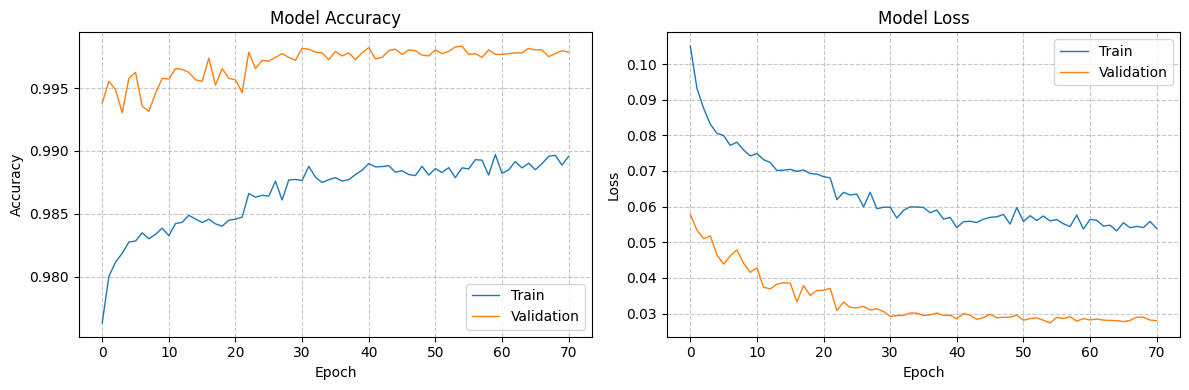

In [ ]:
visualize_training_history(history)